# Process GFSAD rainfed and irrigated cropping layers for Australia

Downloaded from here: https://lpdaac.usgs.gov/products/lgrip30v001/


## Load packages

In [ ]:
import sys
import os
import xarray as xr
import rioxarray as rxr
from rioxarray import merge
from odc.geo.xr import assign_crs
from odc.geo.xr import write_cog

## Combine tiles

In [ ]:
base='/g/data/os22/chad_tmp/Aus_phenology/data/gfsad/'
files = [base+i for i in os.listdir(base)]

tifs = []
for f in files:
    tifs.append(rxr.open_rasterio(f).squeeze().drop_vars('band'))

merged = merge.merge_arrays(tifs)
merged = assign_crs(merged, crs='EPSG:4326')

#save and then reload
write_cog(merged, fname='/g/data/os22/chad_tmp/Aus_phenology/data/croplands_30m.tif')

## Open and reproject to 5 km resolution

This is a tradeoff between high-enough resolution to resolve smaller irrigated regions, while not having too much complexity in the final vector file. Keep in mind the NDVI data is 5 km resolution

In [1]:
import sys
import xarray as xr
import rioxarray as rxr
from odc.geo.xr import assign_crs

# sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
# from _utils import start_local_dask
# start_local_dask()

In [ ]:
#reopen file
ds = rxr.open_rasterio('/g/data/os22/chad_tmp/Aus_phenology/data/croplands_30m.tif',
                      chunks=dict(x=250, y=250)).squeeze().drop_vars('band')
ds.attrs['nodata'] = 0

In [ ]:
#file to reproject too
# ds_path = '/g/data/os22/chad_tmp/NEE_modelling/data/1km/Landcover_1km_monthly_2002_2021.nc'
ds_path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022.nc'
gbox = assign_crs(xr.open_dataset(ds_path), crs='EPSG:4326').odc.geobox

ds = ds.odc.reproject(how=gbox,resampling='mode').compute()
ds = ds.rename('croplands')

In [ ]:
# ds.plot.imshow(size=10)
ds.to_netcdf('/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc')

In [ ]:
ds.odc.explore(
           tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
           attr = 'Esri',
           name = 'Esri Satellite',
           )

### Make a figure.

In [25]:
import contextily as ctx
import matplotlib.pyplot as plt
import distinctipy
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

In [7]:
ds=xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc')['croplands']

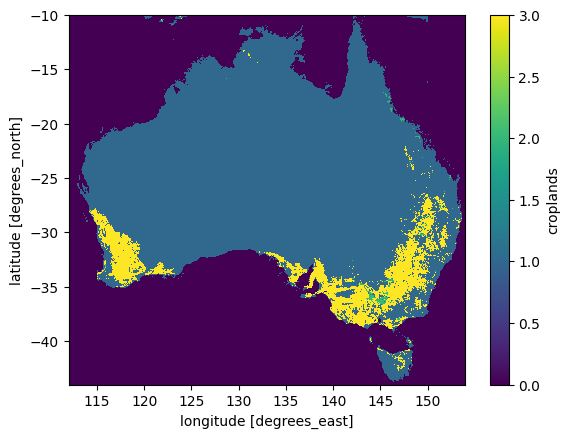

In [20]:
ds.plot()

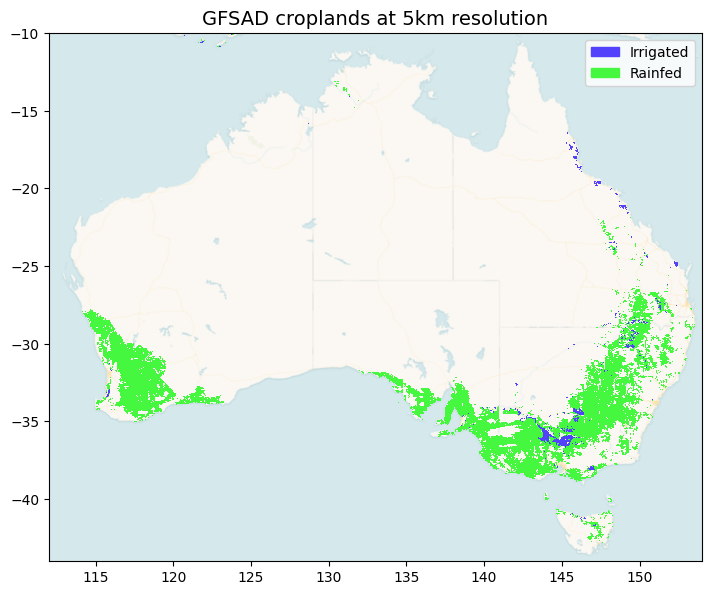

In [29]:
fig,ax=plt.subplots(1,1, figsize=(7,6), sharey=True, sharex=True, layout='constrained')

names=['Rainfed', 'Irrigated']
names.sort()
colors = distinctipy.get_colors(len(names), pastel_factor=0.3)
legend_elements = [Patch(facecolor=c, edgecolor=c,label=n) for c,n in zip(colors,names)]


im= ds.where(ds>1).plot(ax=ax,cmap=LinearSegmentedColormap.from_list(
        'ecoregions', colors, N=len(names)), add_colorbar=False, add_labels=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
# cbar = plt.colorbar(im, shrink=0.75, orientation='vertical')
# cbar.ax.set_title('NDVI', fontsize=10)
ax.set_title('GFSAD croplands at 5km resolution', fontsize=14);

# # Create the figure
# fig, ax = plt.subplots()
# ax.axis(False)
ax.legend(handles=legend_elements, loc="best", fontsize=10, ncol=1);
fig.savefig('/g/data/os22/chad_tmp/Aus_phenology/results/figs/GFSAD_croplands.png', bbox_inches='tight', dpi=300)